# Classifying Glass Types

In [191]:
%matplotlib inline 

import pandas as pd
import numpy as np
from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.style.use('ggplot') 
from sklearn import datasets
from sklearn.metrics import accuracy_score
from math import radians, cos, sin, asin, sqrt

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [192]:
df = pd.read_csv('glass-1.csv')

In [193]:
df.head(2)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,TypeGlass
0,1.515888,12.87795,3.43036,1.40066,73.282,0.68931,8.04468,0.0,0.1224,1
1,1.517642,12.97770,3.53812,1.21127,73.002,0.65205,8.52888,0.0,0.0000,1


In [194]:

dicty = {1:0, 2:1, 3:2, 5:3, 6:4, 7:5}

In [195]:
df = df.replace(dicty)

In [196]:
df.head(2)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,TypeGlass
0,1.515888,12.87795,3.43036,1.40066,73.282,0.68931,8.04468,0.0,0.1224,0
1,1.517642,12.97770,3.53812,1.21127,73.002,0.65205,8.52888,0.0,0.0000,0


In [197]:
df.to_csv('glass_updated.csv')

In [198]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,TypeGlass
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518366,13.413409,2.684516,1.444895,72.655649,0.497235,8.960538,0.177563,0.042611,1.542056
std,0.003037,0.819794,1.442342,0.499361,0.778654,0.652188,1.426621,0.497925,0.092474,1.707648
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,0.000000
25%,1.516526,12.906213,2.113668,1.188800,72.279600,0.121095,8.238360,0.000000,0.000000,0.000000
50%,1.517688,13.303550,3.479750,1.358930,72.789200,0.555795,8.604200,0.000000,0.000000,1.000000
75%,1.519163,13.823912,3.600980,1.628570,73.097200,0.608580,9.177170,0.000000,0.056100,2.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,5.000000


<img src='glass-elements.png'>

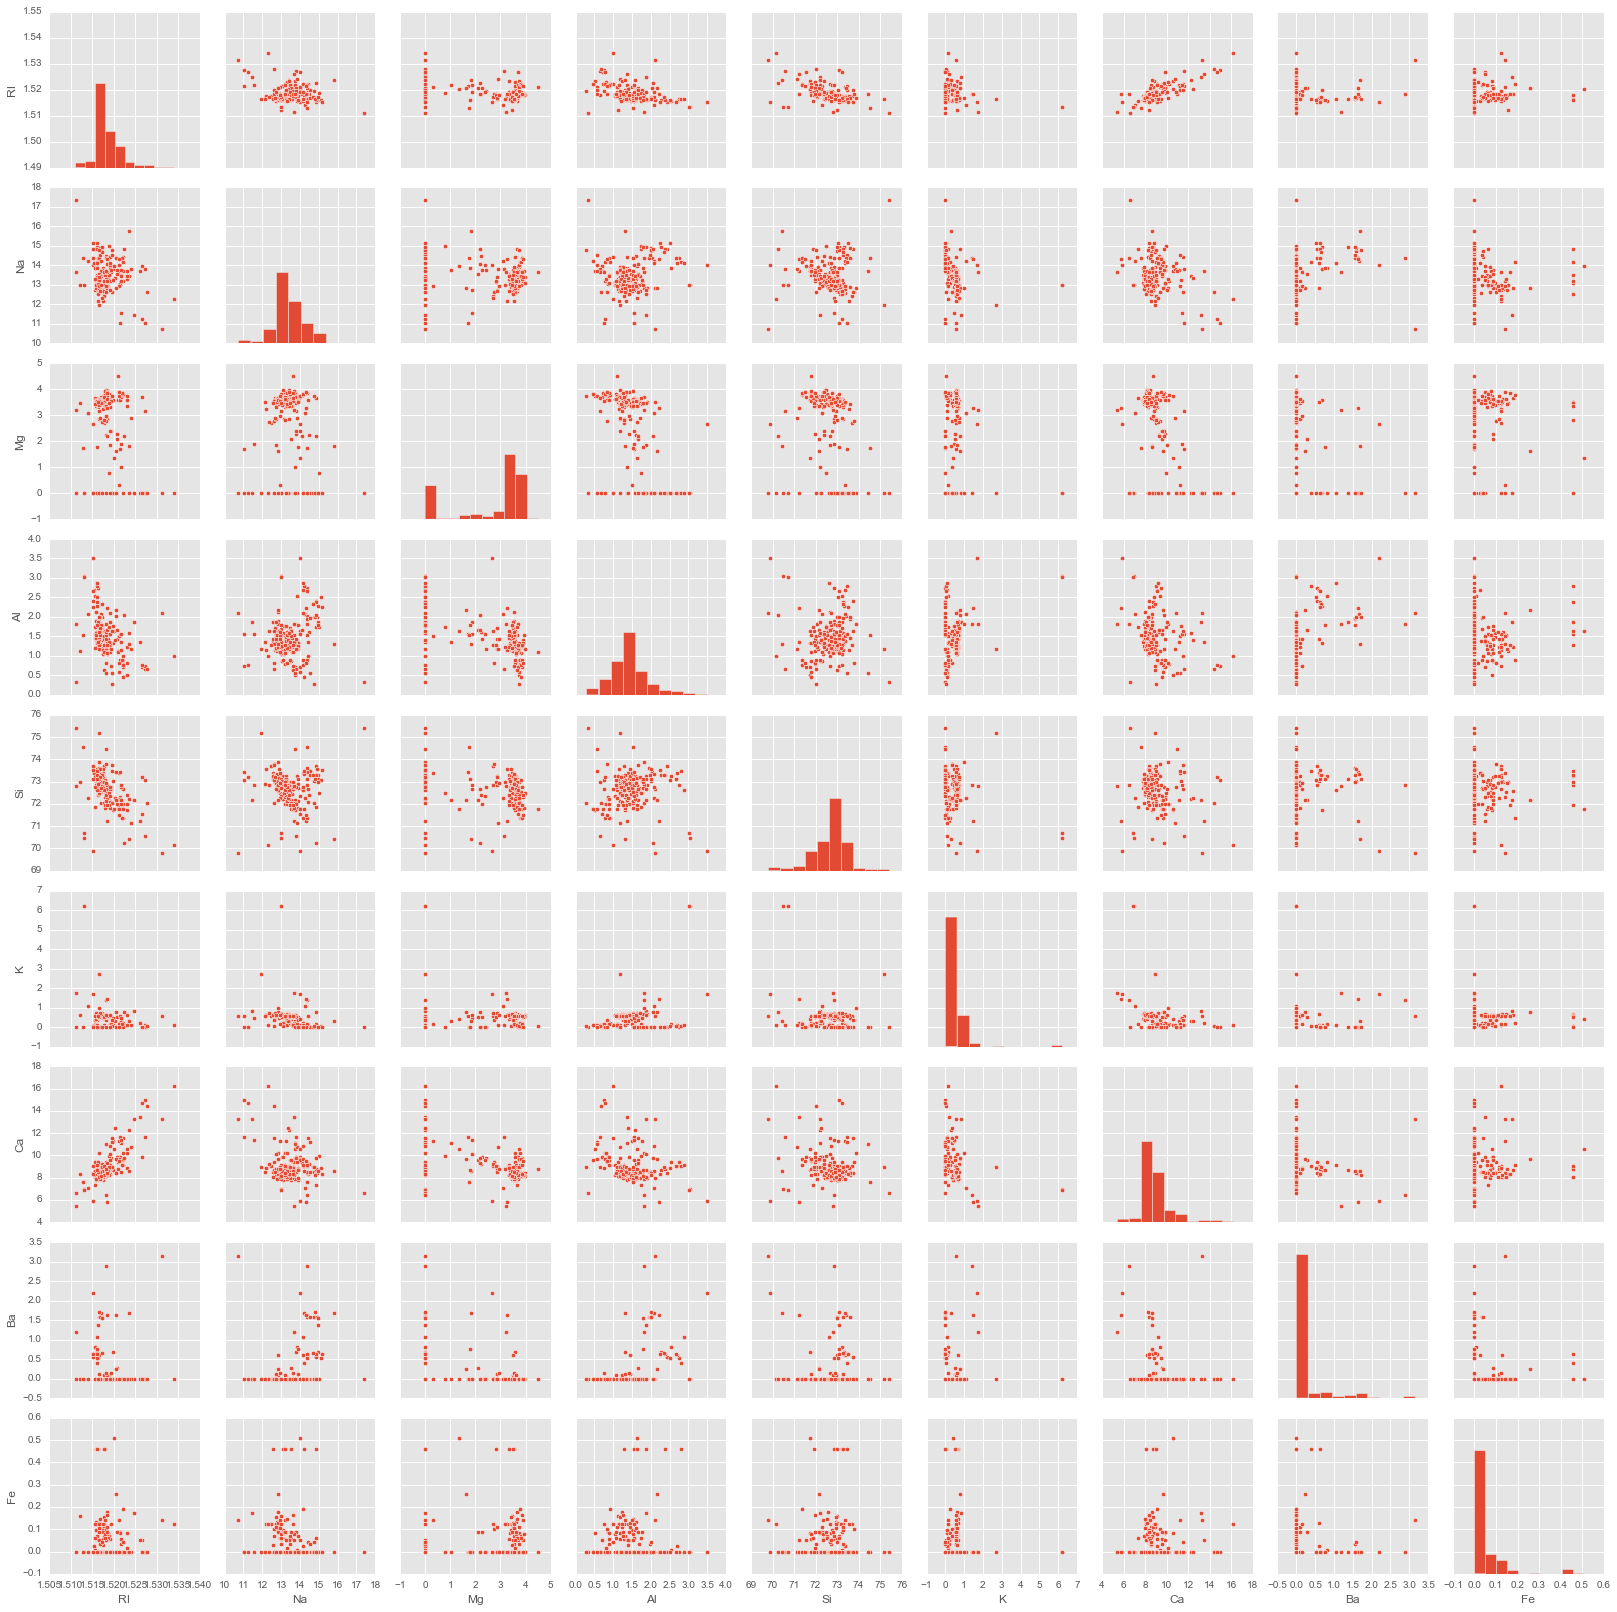

In [199]:
sns.pairplot(df.drop('TypeGlass', axis=1))

In [200]:
'''glass_type = pd.pivot_table(df, index = 'TypeGlass', aggfunc = np.mean)
glass_type = glass_type.reset_index()
glass_type'''

"glass_type = pd.pivot_table(df, index = 'TypeGlass', aggfunc = np.mean)\nglass_type = glass_type.reset_index()\nglass_type"

In [201]:
'''for elements in glass_type.columns[1:]:
    plt.title(elements)
    plt.bar(glass_type['TypeGlass'], glass_type[elements])
    plt.show()'''

"for elements in glass_type.columns[1:]:\n    plt.title(elements)\n    plt.bar(glass_type['TypeGlass'], glass_type[elements])\n    plt.show()"

## Clustering


### Baseline accuracy

In [202]:
(y.value_counts()/214)*100

1    35.514019
0    32.710280
5    13.551402
2     7.943925
3     6.074766
4     4.205607
Name: TypeGlass, dtype: float64

In [203]:
# Get correct label function

from itertools import permutations

def get_correct_labels_score(predicted, real, metric):
    def apply_choice(choice, real, predicted):
        return [real[choice.index(x)] for x in predicted]
   
    poss_pred = list(set(predicted))
    poss_real = list(set(real))
    if len(poss_pred) != len(poss_real):
        print('ERROR in get_correct_labels_score: different number of labels and clusters')
        return
   
    permut = list(permutations(poss_pred))
  
    best_score = metric(real, predicted)
    best_labels = predicted
    for choice in permut:
        new_labels = apply_choice(choice, poss_real, predicted)
        new_score = metric(real, new_labels)
        if new_score > best_score:
            best_score = new_score
            best_labels = new_labels
    return best_labels, best_score

from sklearn.metrics import accuracy_score
#lab, score = get_correct_labels_score(labels, y, accuracy_score)
#print(lab)
#print(score)

In [204]:
# Define target and features

X = df.drop('TypeGlass', axis = 1)
y = df['TypeGlass']

In [205]:
# Rescale feature set

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

### PCA

In [206]:
# PCA

pca = PCA()
pca.fit(X_scaled)
X_reduced = pca.transform(X_scaled)

In [207]:
explained_variance = pca.explained_variance_ratio_
print "Explained Variance:, ", explained_variance

Explained Variance:,  [ 0.27415354  0.22610009  0.15276188  0.12980872  0.10820391  0.06207358
  0.03943612  0.00714153  0.00032064]


In [208]:
cumulative_variance = np.cumsum(explained_variance)
print "Cumulative explained variance: ", cumulative_variance

Cumulative explained variance:  [ 0.27415354  0.50025362  0.6530155   0.78282422  0.89102813  0.95310171
  0.99253783  0.99967936  1.        ]


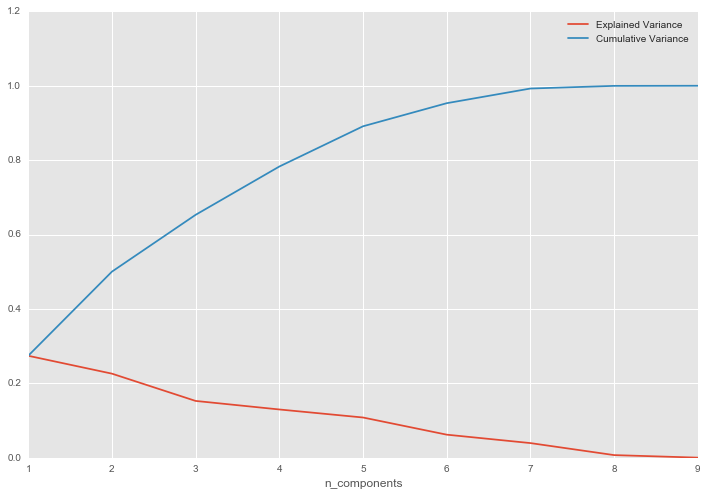

In [243]:
plt.figure(figsize=(12,8))
n_components = list(range(1,10))
plt.plot(n_components, explained_variance, label = 'Explained Variance')
plt.plot(n_components, cumulative_variance, label = 'Cumulative Variance')
plt.legend()
plt.xlabel('n_components')
plt.ylim((0,1.2))
plt.show()

In [210]:
pca = PCA(n_components= 5)
pca.fit(X_scaled)
X_reduced = pca.transform(X_scaled)

### Hierachical Clustering with PCA

In [211]:
Z = linkage(X_reduced, 'ward')
c, coph_dists = cophenet(Z, pdist(X_reduced))
print c
print coph_dists.mean()

0.702842545949
16.5905836406


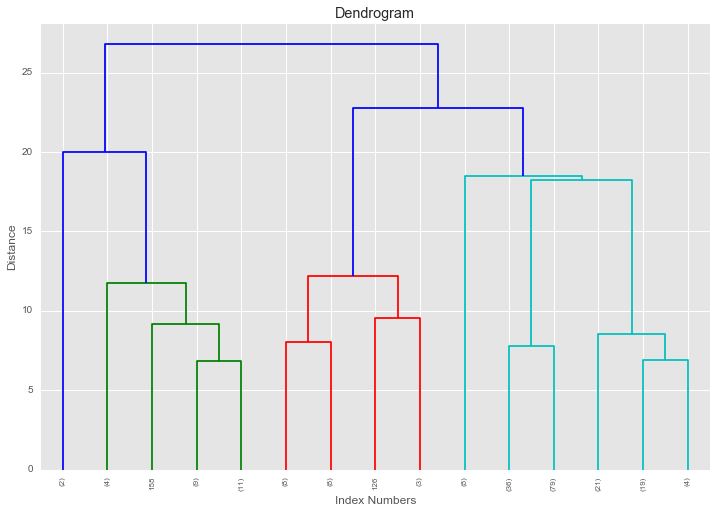

In [242]:
plt.figure(figsize=(12,8))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode = 'lastp',
    p = 15,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

In [213]:
# Clusters

clusters = fcluster(Z, 15, criterion='distance')
print 'Number of clusters: ', clusters.max()

Number of clusters:  6


In [214]:
correct_labels, correct_score = get_correct_labels_score(clusters, y, accuracy_score)

print 'Accuracy score: ', correct_score

Accuracy score:  0.457943925234


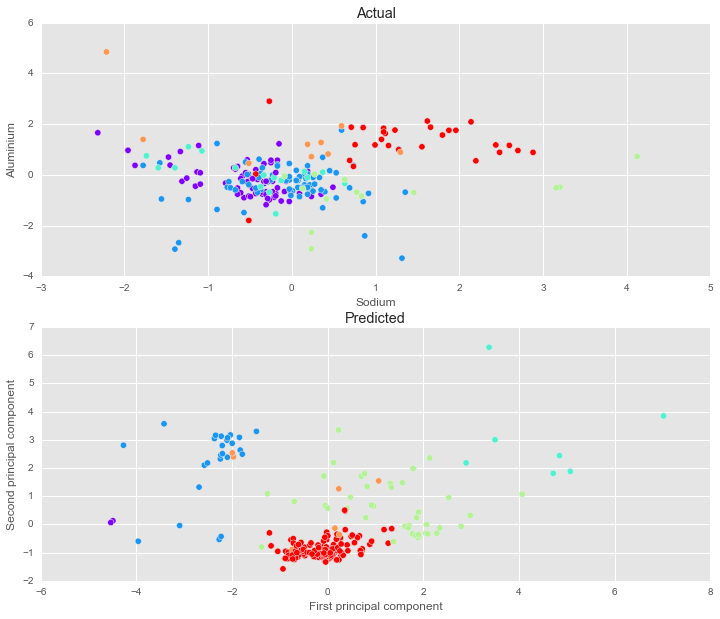

In [215]:

plt.figure(figsize = (12,10))
plt.subplot(2,1,1)
plt.title("Actual")
plt.scatter(X_scaled[:,3], X_scaled[:,1], c= y, cmap='rainbow', s=40 )
plt.xlabel('Sodium')
plt.ylabel('Aluminium')
plt.subplot(2,1,2)
plt.title("Predicted")
plt.scatter(X_reduced[:,0], X_reduced[:,1], c= clusters, cmap='rainbow', s=40 )
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

## Hierachical Clustering without PCA

In [216]:
Z = linkage(X_scaled, 'ward')
c, coph_dists = cophenet(Z, pdist(X_scaled))
print c
print coph_dists.mean()

0.712581747033
16.42360917


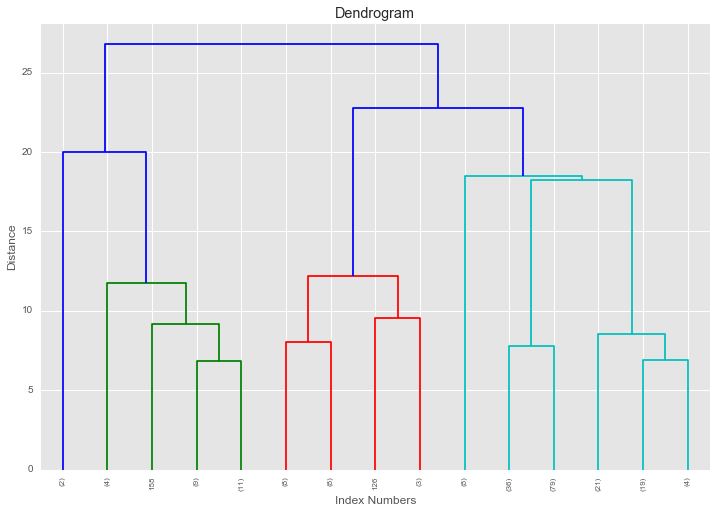

In [241]:
plt.figure(figsize=(12,8))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode = 'lastp',
    p = 15,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

In [218]:
clusters = fcluster(Z, 15, criterion='distance')
print 'Number of clusters: ', clusters.max()

Number of clusters:  6


In [219]:
correct_labels, correct_score = get_correct_labels_score(clusters, y, accuracy_score)

print 'Accuracy score: ', correct_score


Accuracy score:  0.523364485981


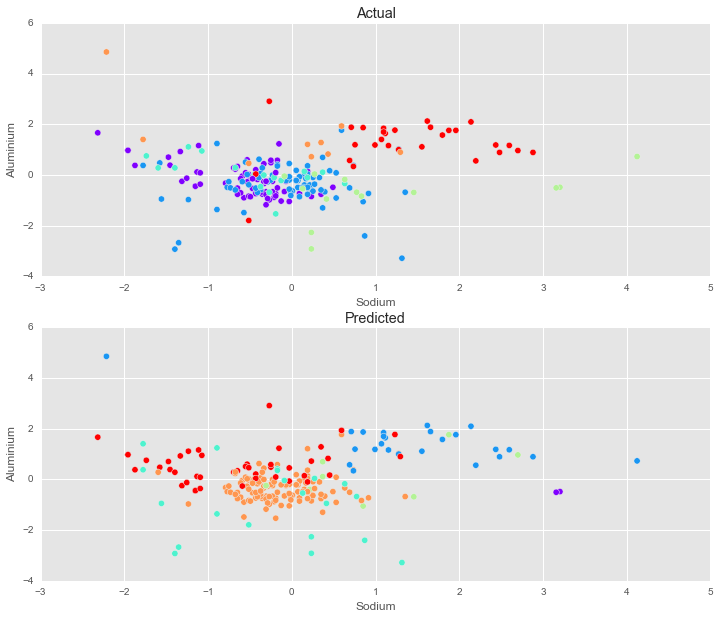

In [220]:
plt.figure(figsize = (12,10))
plt.subplot(2,1,1)
plt.title("Actual")
plt.scatter(X_scaled[:,3], X_scaled[:,1], c= y, cmap='rainbow', s=40 )
plt.xlabel('Sodium')
plt.ylabel('Aluminium')
plt.subplot(2,1,2)
plt.title("Predicted")
plt.scatter(X_scaled[:,3], X_scaled[:,1], c= clusters, cmap='rainbow', s=40 )
plt.xlabel('Sodium')
plt.ylabel('Aluminium')
plt.show()

## KMeans

In [221]:
from sklearn.cluster import KMeans
clus = KMeans(n_clusters=6)
model = clus.fit(X_scaled)
clus_lab = model.labels_

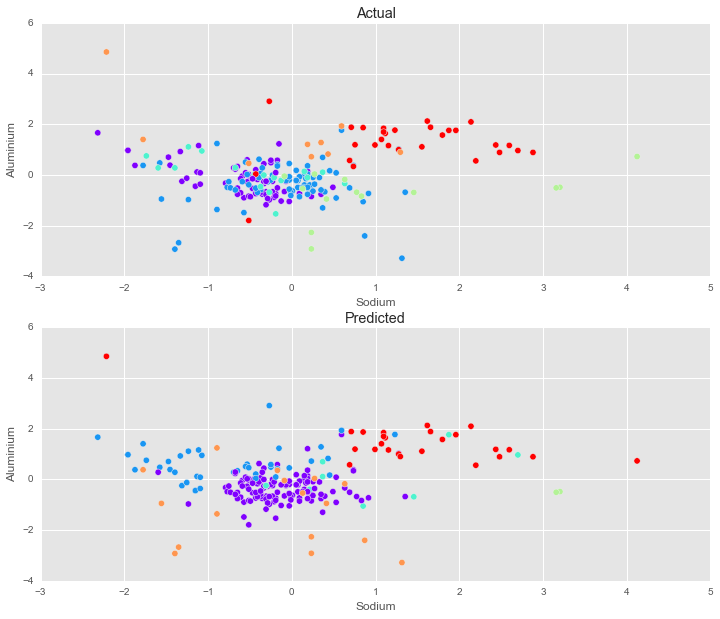

In [222]:
plt.figure(figsize = (12,10))
plt.subplot(2,1,1)
plt.title("Actual")
plt.scatter(X_scaled[:,3], X_scaled[:,1], c= y, cmap='rainbow', s=40 )
plt.xlabel('Sodium')
plt.ylabel('Aluminium')
plt.subplot(2,1,2)
plt.title("Predicted")
plt.scatter(X_scaled[:,3], X_scaled[:,1], c= clus_lab, cmap='rainbow', s=40 )
plt.xlabel('Sodium')
plt.ylabel('Aluminium')
plt.show()

In [223]:
correct_labels, correct_score = get_correct_labels_score(clus_lab, y, accuracy_score)

print 'Accuracy score: ', correct_score

Accuracy score:  0.523364485981


## DBSCAN

In [224]:
db = DBSCAN(eps= 0.9, min_samples= 3)  
y_db = db.fit_predict(X_scaled) 
labels = db.labels_
print np.unique(db.labels_)

[-1  0  1  2  3  4]


In [225]:
correct_labels, correct_score = get_correct_labels_score(labels, y, accuracy_score)

print 'Accuracy score: ', correct_score

Accuracy score:  0.467289719626


# Classification

## KNN

In [226]:
cl = KNeighborsClassifier()
variables = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,11,12]}

model = GridSearchCV(cl, param_grid=variables, cv=5, scoring = 'accuracy')
fitted_model = model.fit(X_scaled, y)


In [227]:
print fitted_model.best_score_
print fitted_model.best_params_

0.719626168224
{'n_neighbors': 1}


In [228]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

cl = KNeighborsClassifier(n_neighbors = 1)
model = cl.fit(X_scaled, y)
predictions = model.predict(X_scaled)

In [229]:
correct_labels, correct_score = get_correct_labels_score(predictions, y, accuracy_score)

print 'Accuracy score: ', correct_score

Accuracy score:  1.0


In [230]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.33)

In [231]:
cl = KNeighborsClassifier(n_neighbors = 1)
model = cl.fit(X_train, y_train)
predictions = model.predict(X_test)

In [232]:
print 'Accuracy score: ', accuracy_score(y_test, predictions)

Accuracy score:  0.760563380282


In [233]:
from sklearn.metrics import classification_report, confusion_matrix

print confusion_matrix(y_test, predictions)

[[22  2  4  0  0  0]
 [ 3 21  1  0  0  0]
 [ 1  2  0  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  1  0]
 [ 1  2  0  1  0  9]]


In [234]:
print classification_report(y_test, predictions)

             precision    recall  f1-score   support

          0       0.81      0.79      0.80        28
          1       0.78      0.84      0.81        25
          2       0.00      0.00      0.00         3
          3       0.50      1.00      0.67         1
          4       1.00      1.00      1.00         1
          5       1.00      0.69      0.82        13

avg / total       0.80      0.76      0.77        71



## Random forests

In [235]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict


trees = DecisionTreeClassifier()
bagging = BaggingClassifier(trees, n_estimators=100, random_state=42)
print "Trees Score:\t", cross_val_score(trees, X_scaled, y, cv=5).mean()
print "Bagging Score:\t", cross_val_score(bagging, X_scaled, y, cv=5).mean()

Trees Score:	0.696625054532
Bagging Score:	0.758161179905


In [236]:
predictions = cross_val_predict(bagging, X_scaled, y, cv=5 )

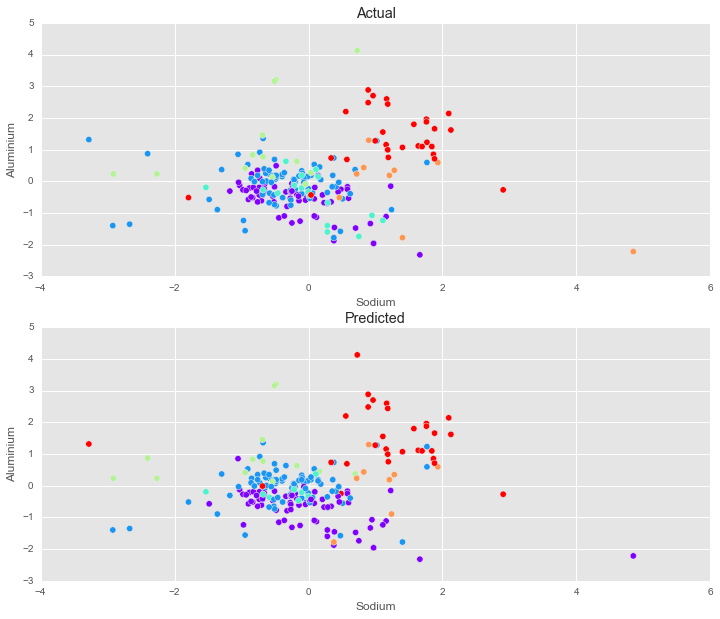

In [237]:
plt.figure(figsize = (12,10))
plt.subplot(2,1,1)
plt.title("Actual")
plt.scatter(X_scaled[:,1], X_scaled[:,3], c= y, cmap='rainbow', s=40 )
plt.xlabel('Sodium')
plt.ylabel('Aluminium')
plt.subplot(2,1,2)
plt.title("Predicted")
plt.scatter(X_scaled[:,1], X_scaled[:,3], c= predictions, cmap='rainbow', s=40 )
plt.xlabel('Sodium')
plt.ylabel('Aluminium')
plt.show()